# Using the PennyLaneTranspiler in Qamomile
This tutorial demonstrates the usage of the PennyLaneTranspiler in Qamomile and provides key examples to guide users in applying it effectively.

## Translating a Hamiltonian into PennyLane

We begin by defining a Hamiltonian as a test example and use our transpiler to convert it into a PennyLane-compatible representation. This step shows how seamlessly the Hamiltonian defined in our own library’s format can be translated into operators recognized by PennyLane.

In [1]:
import pennylane as qml
import numpy as np
import qamomile
from qamomile.pennylane.transpiler import PennylaneTranspiler
from qamomile.core.operator import Hamiltonian, Pauli, X, Y, Z
from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.circuit import (
    QuantumCircuit,
    SingleQubitGate,
    TwoQubitGate,
    ParametricSingleQubitGate,
    ParametricTwoQubitGate,
    SingleQubitGateType,
    TwoQubitGateType,
    ParametricSingleQubitGateType,
    ParametricTwoQubitGateType,
    Parameter
)

import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import networkx as nx

In this snippet, we start from a custom-defined Hamiltonian using various Pauli operators (X, Y, Z) and then employ `PennylaneTranspiler` to convert it into a format directly suitable for PennyLane devices. By inspecting `ops_first_term` and printing out `pennylane_hamiltonian`, we can verify the correctness of the translation.

In [2]:
hamiltonian = Hamiltonian()
hamiltonian += X(0)*Z(1)
hamiltonian += Y(0)*Y(1)*Z(2)*X(3)*X(4)

transpiler = PennylaneTranspiler()
pennylane_hamiltonian = transpiler.transpile_hamiltonian(hamiltonian)

ops_first_term = pennylane_hamiltonian.terms()[1][0]
print(pennylane_hamiltonian)

1.0 * (X(0) @ Z(1) @ I(2) @ I(3) @ I(4)) + 1.0 * (Y(0) @ Y(1) @ Z(2) @ X(3) @ X(4))


## Constructing a Parameterized Quantum Circuit

Next, we build a parameterized quantum circuit using QamomileCircuit. We include single-qubit rotations (e.g., rx, ry, rz) and controlled variants (crx, crz, cry), as well as two-qubit entangling gates (rxx, ryy, rzz). The parameters (theta, beta, gamma) allow for flexible variational adjustments.

In [3]:
qc = QamomileCircuit(3)
theta = Parameter("theta")
beta = Parameter("beta")
gamma = Parameter("gamma")

qc.rx(theta, 0)
qc.ry(beta, 1)
qc.rz(gamma, 2)
qc.crx(gamma, 0 ,1)
qc.crz(theta, 1 ,2)
qc.cry(beta, 2 ,0)
qc.rxx(gamma, 0 ,1)
qc.ryy(theta, 1 ,2)
qc.rzz(beta, 2 ,0)

transpiler = PennylaneTranspiler()
QNode = transpiler.transpile_circuit(qc)

## Formulating the MaxCut Problem and Converting it into a Quantum Form

In the following part, we demonstrate how to take a classical optimization problem—MaxCut—and encode it into an Ising-form Hamiltonian. We then construct a QAOA-style ansatz circuit that, when executed and optimized, attempts to solve the MaxCut instance.

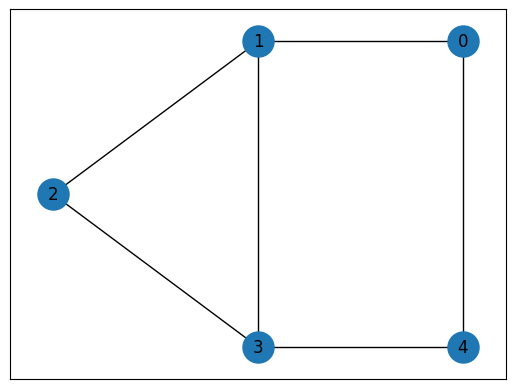

In [4]:
def maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem

def maxcut_instance():
    # Construct a simple graph for a MaxCut instance
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3, 4])
    G.add_edges_from([(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])
    E = [list(edge) for edge in G.edges]
    instance_data = {"V": G.number_of_nodes(), "E": E}
    pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
    nx.draw_networkx(G, pos, node_size=500)
    return instance_data

problem = maxcut_problem()
instance_data = maxcut_instance()
interpreter = jm.Interpreter(instance_data)
compiled_instance = interpreter.eval_problem(problem)

# Convert the compiled problem into a QAOA form.
qaoa_converter = qamomile.core.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode()

p = 5
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

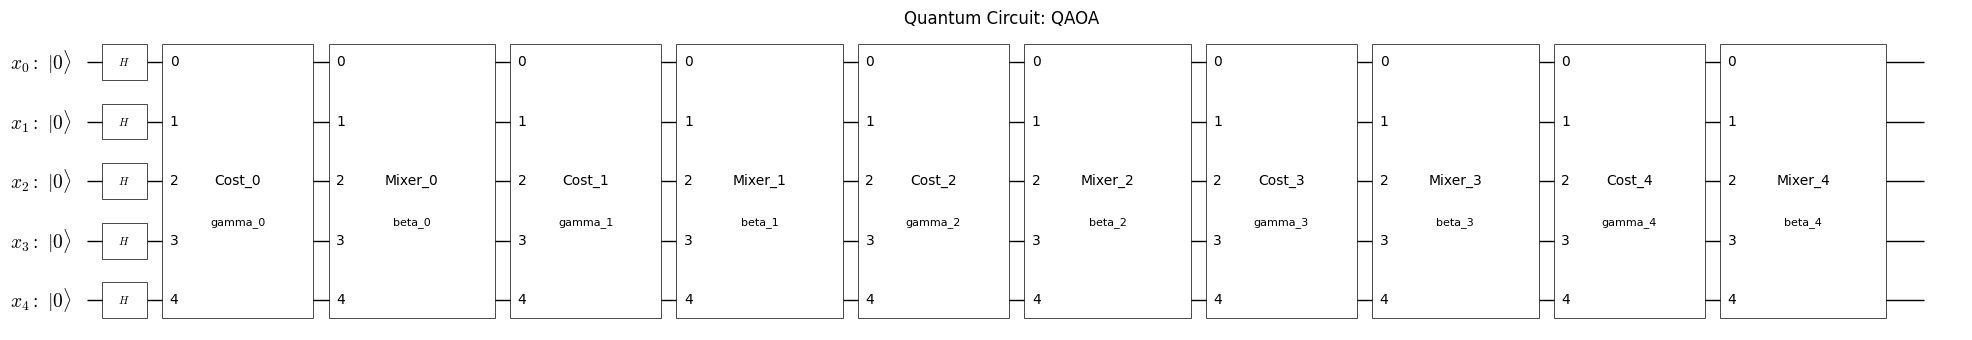

In [5]:
from qamomile.core.circuit.drawer import plot_quantum_circuit

plot_quantum_circuit(qaoa_circuit)

We have now translated the MaxCut problem into a cost Hamiltonian suitable for a QAOA-like algorithm. The parameter `p` determines the number of layers of problem and mixer Hamiltonians. Each layer’s parameters are variational and will be tuned to minimize the expvalue, ideally leading to a good solution to the MaxCut instance.

## Transpiling and Executing the QAOA Circuit in PennyLane

With the QAOA circuit and Hamiltonian defined, we use the transpiler again, this time to convert the QAOA circuit and cost Hamiltonian into PennyLane forms:

In [6]:
from pennylane import numpy as p_np
transpiler = PennylaneTranspiler()
circ_func = transpiler.transpile_circuit(qaoa_circuit)
qml_hamiltonian = transpiler.transpile_hamiltonian(qaoa_hamiltonian)

dev = qml.device("default.qubit", wires=qaoa_circuit.num_qubits)

@qml.qnode(dev)
def circuit(params, return_samples=False):
    circ_func(params)
    if return_samples:
        return qml.sample()
    return qml.expval(qml_hamiltonian)

parameters = p_np.array([np.pi/4, np.pi/4]*p, requires_grad=True)
print("Initial Expectation Value:", circuit(parameters))
cost_history = []
cost_history.append(circuit(parameters))

Initial Expectation Value: 0.6975904406316913


Here, `circ_func` is the PennyLane circuit function generated from the QAOA ansatz. Evaluating `circuit(p)` gives the expectation value of the cost Hamiltonian for the given set of parameters `p`.

## Optimizing the Parameters

Finally, we leverage PennyLane’s optimizers to update the parameters and attempt to find those that yield better results (e.g., lower cost for the MaxCut objective):

In [7]:
max_iterations = 1000
optimizer = qml.GradientDescentOptimizer(stepsize=5e-2)
for i in range(max_iterations):
    parameters, loss= optimizer.step_and_cost(circuit, parameters)
    cost_history.append(loss)
    
print("Optimal Parameters")
print(parameters)

Optimal Parameters
[ 0.35271931  1.02327598  0.74961704  1.12583207  0.91321306 -0.38421535
  1.08607428  1.27879381  1.12025286  1.42425253]


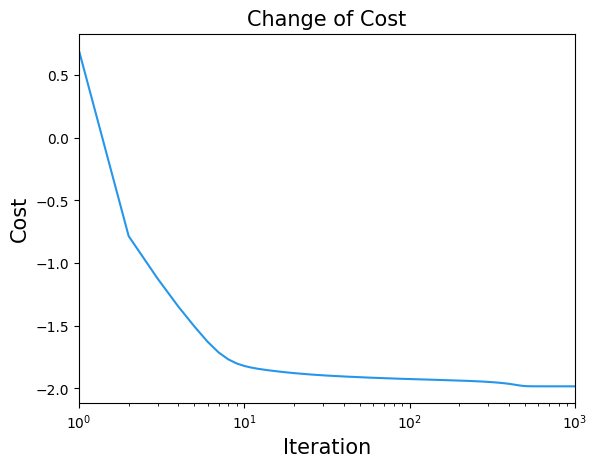

In [8]:
import matplotlib.pyplot as plt

plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, max_iterations)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

Once the optimized parameters are obtained, we use PennyLane's QNode to sample from the parameterized quantum circuit to get the circuit counts.

In [9]:
dev_counts = qml.device("default.qubit", wires=qaoa_circuit.num_qubits, shots=1000)
@qml.qnode(dev_counts)
def circuit_counts(params):
    circ_func(params)
    return qml.counts()
result = circuit_counts(parameters)

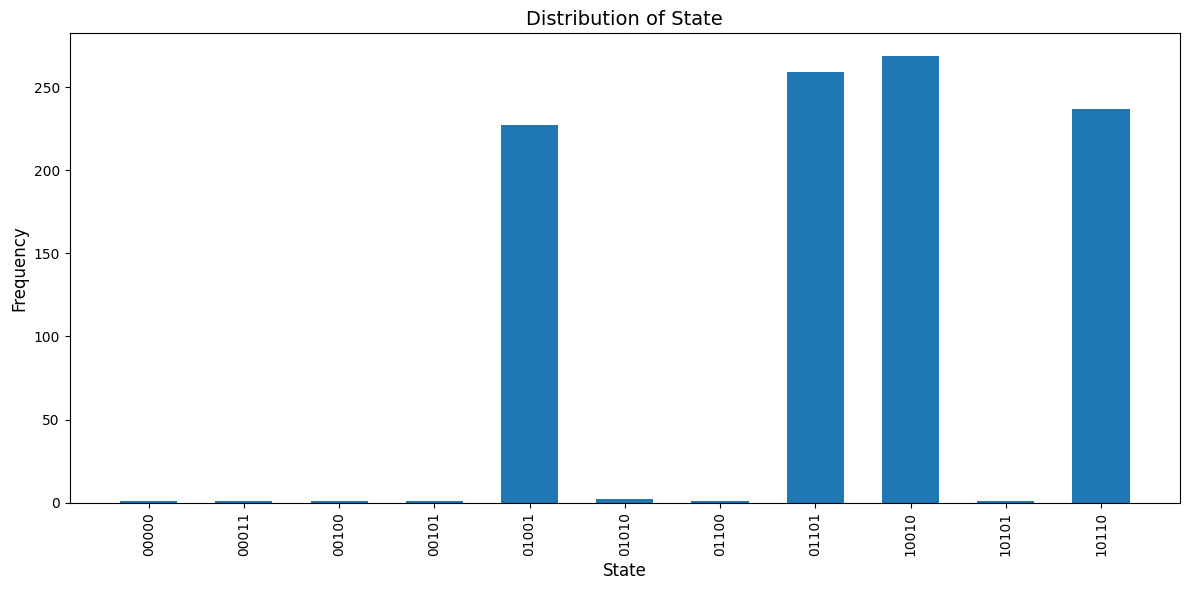

In [10]:
# Prepare data for plotting
keys = list(result.keys())
values = list(result.values())

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(keys, values, width=0.6)
plt.xlabel("State", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of State", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

## Evaluating the Results
From the `circuit_counts` obtained earlier, we can transfer them to a sampleset by `qaoa_converter.decode`.
The sampleset can select only the feasible solutions and then we examine the distribution of the objective function values.

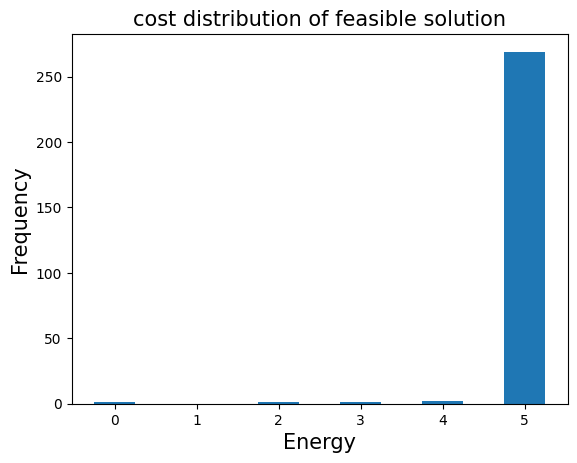

In [11]:
import matplotlib.pyplot as plt

sampleset = qaoa_converter.decode(transpiler, result) 
feasible_ids = sampleset.summary.query("feasible == True").index
energies = []
frequencies = []
for entry in sampleset.raw.objectives.entries:
    energies.append(entry.value)
    feasible_count = len([_id for _id in entry.ids if _id in feasible_ids])
    frequencies.append(feasible_count)

plt.bar(energies, frequencies, width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()